In [139]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd
import openpyxl
import scipy.optimize

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

# Fotoconductividad

In [140]:
def Minimos_cuadrados(x,y,n=1):
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)

    xsol = np.linalg.solve(AT,bT)
    
    return xsol

def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
        
    return y

def GetError(x,y,p,n=1):
    
    l = x.shape[0]
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    # Residuos
    R = y - np.dot(A,p)
    
    sigma2 = np.dot(R.T,R)/(len(y)-len(p))
    
    Cov = sigma2*np.linalg.inv(np.dot(A.T,A))
    
    R2 = None
    if np.shape(Cov) == (2,2):
        R2 = (Cov[0][1]**2)/(Cov[0][0]*Cov[1][1])

    return (Cov,R2,R)

def Get_sigma(Cov):
    sigmaai = np.sqrt(np.diagonal(Cov))
    return sigmaai[::-1]

def Error_relativo(X_real,X_exp):
    return (np.abs(X_exp - X_real)/X_real)

def presicion(d,v):
    p = (d/v)
    if p <= 0.1:
        return p,True
    else:
        return p,False
    
def exactitud(xr,xm,d):
    e = (np.abs(xr-xm))
    if e <= (2.5*d):
        return e/d,True
    else:
        return e/d,False

X = sym.Symbol('x',real=True)
Y = sym.Symbol('y',real=True)

In [141]:
c = 299798458*1e09 #nm/s
c_ = 299798458 #m/s
me = 0.51099895*1e06/(c**2) #eV/c**2
me_ = 0.51099895*1e06/(c_**2) #eV/c**2
mp = 938.27208816*1e06/(c**2) #eV/c**2
mn = 939.56542052*1e06/(c**2) #eV/c**2
h = 4.136667696*1e-15 #eV*s
h_barra = 6.582119569*1e-16 #eV*s
e_0 = 55.26349406*1e-03 #e**2/(cV*nm)
e = 1 #e
a_0 = 0.0529177210903 #nm
Ry = 13.605693122994 #eV
Miu_B = 5.7883818066*1e-05 #eV/T

# Datos

In [142]:
# corriente medida a 20V y bajando de a 1V para angulos del polarizador de 0 hasta 90 grados
V = np.array([20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0])
A0 = np.array([22., 22., 21.5, 21., 19., 18.7, 17.5, 15.5, 14.1, 13.5, 12.1, 10.9, 9.7, 8.6, 7.6, 6.4, 5.2, 3.9, 2.7, 1.4,0.0])*(10**(-3))
A10 = np.array([10.8, 10.2, 9.8, 9.4, 8.7, 8.2, 7.6, 7.1, 6.6, 6.0, 5.5, 5.0, 4.4, 3.9, 3.3, 2.8, 2.2, 1.7, 1.2, 0.6, 0.0])*(10**(-3))
A20 = np.array([11.5, 11.1, 10.5, 10.0, 9.4, 8.9, 8.4, 7.8, 7.2, 6.6, 6.1, 5.4, 4.9, 4.3, 3.7, 3.1, 2.5, 1.9, 1.3, 0.6, 0.0])*(10**(-3))
A30 = np.array([11.2, 10.7, 10.2, 9.8, 9.2, 8.6, 8.1, 7.6, 7.0, 6.4, 5.8, 5.2, 4.65, 4.1, 3.5, 2.9, 2.3, 1.8, 1.2, 0.58, 0.0])*(10**(-3))
A40 = np.array([11.0, 10.5, 10.1, 9.5, 9.0, 8.3, 7.8, 7.3, 6.7, 6.1, 5.5, 5.0, 4.5, 3.9, 3.4, 2.8, 2.26, 1.75, 1.17, 0.58, 0.0])*(10**(-3))
A50 = np.array([9.9, 9.3, 8.9, 8.2, 7.8, 7.4, 6.85, 6.5, 5.9, 5.4, 5.0, 4.4, 3.95, 3.4, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.0])*(10**(-3))
A60 = np.array([9.0, 8.4, 8.0, 7.6, 6.8, 6.6, 6.0, 5.5, 5.2, 4.7, 4.3, 3.9, 3.4, 3.0, 2.6, 2.2, 1.8, 1.36, 0.92, 0.47, 0.0])*(10**(-3))
A70 = np.array([7.6, 7.2, 6.9, 6.4, 6.0, 5.6, 5.2, 4.75, 4.4, 4.0, 3.6, 3.2, 2.9, 2.5, 2.15, 1.82, 1.46, 1.12, 0.75, 0.39, 0.0])*(10**(-3))
A80 = np.array([5.9, 5.7, 5.3, 4.9, 4.5, 4.3, 3.9, 3.6, 3.3, 2.95, 2.6, 2.33, 2.1, 1.82, 1.53, 1.3, 1.06, 0.82, 0.53, 0.27, 0.0])*(10**(-3))
A90 = np.array([5.2, 4.7, 4.2, 3.95, 3.5, 3.1, 3.3, 3.0, 2.76, 2.47, 2.16, 1.93, 1.66, 1.43, 1.19, 0.95, 0.72, 0.55, 0.4, 0.21, 0.0])*(10**(-3))
A = np.array([A0,A10,A20,A30,A40,A50,A60,A70,A80,A90])
grados = np.array([0,10,20,30,40,50,60,70,80,90])

- Irradianza constante:

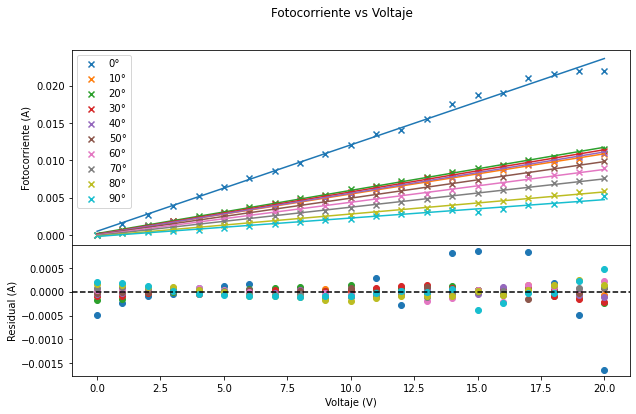

In [143]:
C = []
dC = []
R = []
dR = []
R2 = []
Models = []
Residuals = []
_x = np.linspace(np.min(V),np.max(V),50)
for i in A:
    param = Minimos_cuadrados(V,i)
    Cov,r2,r = GetError(V,i,param)
    deltas = Get_sigma(Cov)
    R.append(1/(param[-1]))
    dR.append((deltas[0])/(param[-1]**2))
    C.append(param[-1])
    dC.append(deltas[0])
    Models.append(GetModel(_x,param))
    Residuals.append(r)
    R2.append(r2)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle('Fotocorriente vs Voltaje')
n = 0
for a in A:
    axs[0].scatter(V,a,label=str(grados[n])+"°",marker='x')
    n += 1
for i in range(len(grados)):
    axs[0].plot(_x,Models[i])
    axs[1].scatter(V,Residuals[i])
axs[0].set_ylabel('Fotocorriente (A)')
axs[0].legend()
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Voltaje (V)')
axs[1].set_ylabel('Residual (A)')
plt.show()

In [144]:
R

[863.7128435221548,
 1854.0813869491933,
 1729.1713451605656,
 1766.9466244435278,
 1806.621149198753,
 2041.3573700954412,
 2270.1140953447925,
 2633.9194089074363,
 3376.156443197267,
 4054.1252040225327]

In [145]:
dR

[14.513898160612134,
 7.288718944982227,
 11.255995946912519,
 10.235861222525001,
 6.534625448087441,
 8.72137175024447,
 20.932780790681655,
 20.58207018723651,
 52.041284581846234,
 107.74568995925188]

- Voltaje constante:

In [146]:
A = np.array([A10,A20,A30,A40,A50,A60,A70,A80,A90])
grados = np.array([10,20,30,40,50,60,70,80,90])

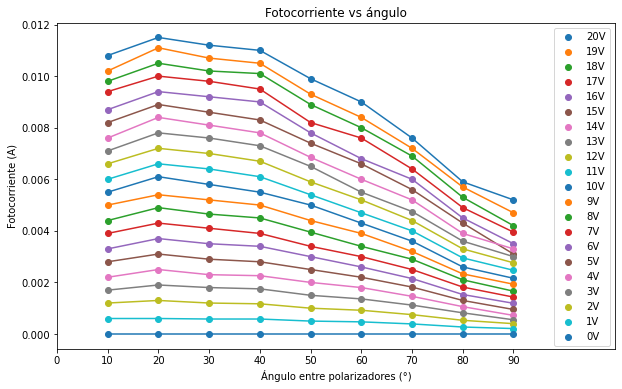

In [147]:
plt.figure(figsize=(10, 6))
for i in range(len(V)):
    plt.scatter((grados),A[:,i],label=str(int(V[i]))+'V')
    plt.plot((grados),A[:,i])
plt.ylabel('Fotocorriente (A)')
plt.xlabel('Ángulo entre polarizadores (°)')
plt.title('Fotocorriente vs ángulo')
plt.xlim(5,110)
plt.xticks(np.linspace(0,90,10))
plt.legend()

C:\Users\ASUS\AppData\Local\Temp/ipykernel_12824/2739310146.py:43: RuntimeWarning: invalid value encountered in double_scalars
  R2 = (Cov[0][1]**2)/(Cov[0][0]*Cov[1][1])


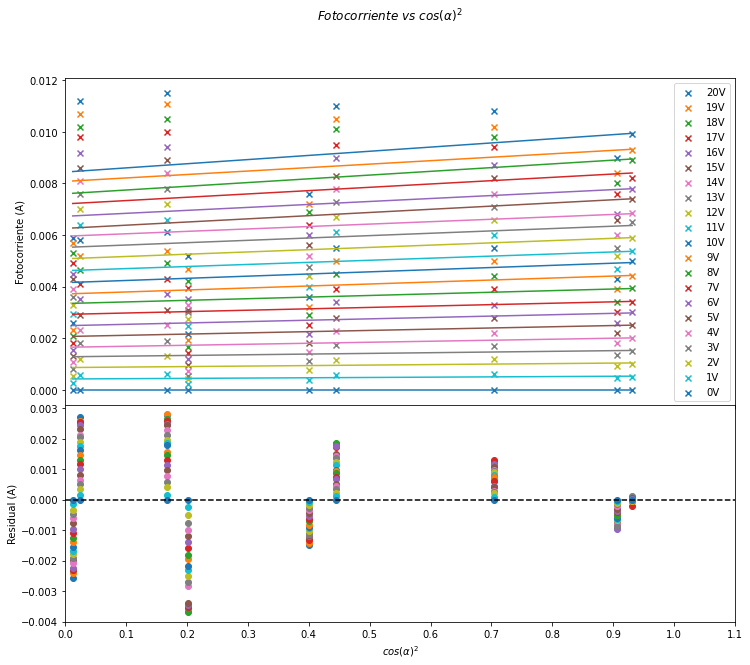

In [148]:
m = []
dm = []
R2 = []
_x = np.linspace(np.min(np.cos(grados)**2),np.max(np.cos(grados)**2),50)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle(r'$Fotocorriente$ $vs$ $cos(\alpha)^{2}$')
for i in range(len(V)):
    param = Minimos_cuadrados(np.cos(grados)**2,A[:,i])
    Cov,r2,r = GetError(np.cos(grados)**2,A[:,i],param)
    m.append(param[-1])
    dm.append(Get_sigma(Cov)[0])
    R2.append(r2)
    axs[0].scatter(np.cos(grados)**2,A[:,i],label=str(int(V[i]))+'V',marker='x')
    axs[0].plot(_x,GetModel(_x,param))
    axs[1].scatter(np.cos(grados)**2,r)
axs[0].set_ylabel('Fotocorriente (A)')
axs[0].legend()
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel(r'$cos(\alpha)^{2}$')
axs[1].set_ylabel('Residual (A)')
axs[1].set_xlim(0,1.1)
axs[1].set_xticks(np.linspace(0,1.1,12))

In [149]:
m

[0.0016125257691112093,
 0.0013387793412570116,
 0.0014477883732557978,
 0.0012870693507672424,
 0.0011492053226788567,
 0.0012328649228304457,
 0.0009378867831428078,
 0.0009133039842117872,
 0.0008806864401560821,
 0.0008067581390536728,
 0.0008379535435355935,
 0.0007716449078253877,
 0.0006258310386689526,
 0.0005416873778250594,
 0.0005320876611926665,
 0.00047325087005603426,
 0.0003904192450564226,
 0.0002644364952629286,
 0.00019235390465688194,
 0.00011672677507976058,
 0.0]

In [150]:
dm

[0.0024411950804985143,
 0.0024042559935895844,
 0.0023706231547525377,
 0.0023110716344433317,
 0.0022478329980319934,
 0.0021244527694787726,
 0.00194996326623533,
 0.0018598338088883248,
 0.0017098584833578634,
 0.0015869137694765336,
 0.0014869780278697951,
 0.0013345857649710133,
 0.00121579397694872,
 0.0010795512611191792,
 0.0009377960127546498,
 0.0007833553330328149,
 0.000630347783669544,
 0.0004888561202186448,
 0.00033118613651408066,
 0.00014951853398868483,
 0.0]